In [1]:
from skimage.filters import threshold_local
from scipy.spatial import distance as dist
import numpy as np
import argparse
import cv2
import imutils
from imutils import contours
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image = cv2.imread('img/img2.jpg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

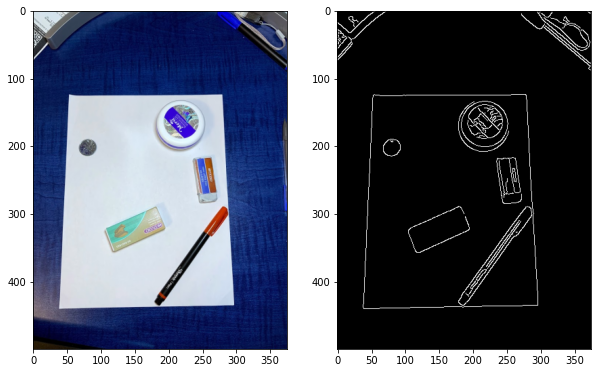

In [4]:
plt.figure(figsize=(10,12))
plt.subplot(121), plt.imshow(image)
plt.subplot(122), plt.imshow(edged, 'gray')
plt.show()

In [5]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

In [6]:
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print(approx)
    if len(approx) == 4:
        screenCnt = approx
        break

[[[ 53 125]]

 [[ 39 440]]

 [[296 435]]

 [[279 125]]]


In [7]:
def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    return np.array([tl, tr, br, bl], dtype="float32")

In [8]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([ [0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [9]:
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.figure(figsize=(8,6))
plt.imshow(image)

array([[[215, 224, 234],
        [214, 224, 234],
        [215, 225, 235],
        ...,
        [202, 220, 233],
        [187, 206, 211],
        [147, 166, 170]],

       [[215, 224, 233],
        [214, 225, 233],
        [215, 226, 234],
        ...,
        [200, 217, 229],
        [201, 217, 226],
        [163, 179, 188]],

       [[214, 223, 232],
        [214, 225, 233],
        [214, 225, 233],
        ...,
        [208, 223, 233],
        [201, 217, 230],
        [177, 193, 207]],

       ...,

       [[ 43,  30,   8],
        [ 43,  30,   8],
        [ 42,  29,   7],
        ...,
        [  3,   9,  63],
        [  2,   9,  62],
        [  1,   7,  60]],

       [[ 43,  30,   8],
        [ 38,  25,   3],
        [ 39,  26,   4],
        ...,
        [  3,  10,  65],
        [  5,  12,  65],
        [  3,  10,  63]],

       [[ 36,  23,   1],
        [ 38,  25,   3],
        [ 42,  29,   7],
        ...,
        [  3,  14,  66],
        [  1,  14,  65],
        [  4,  21,  72]]

In [11]:
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

In [12]:
# warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# T = threshold_local(warped, 11, offset = 10, method = "gaussian")
# warped = (warped > T).astype("uint8") * 255

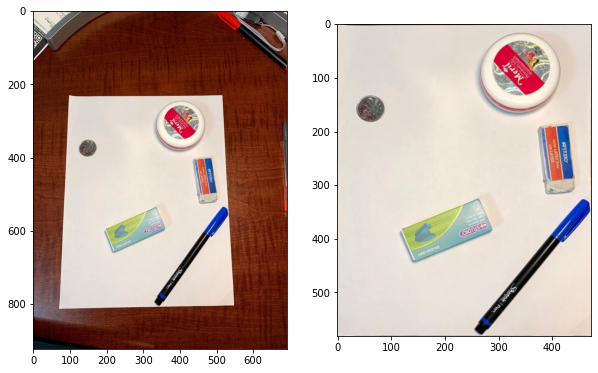

In [13]:
plt.figure(figsize=(10,12))
plt.subplot(121), plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
def get_contours_with_median(img, thr=[180, 200]):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dilated_img = cv2.dilate(img_gray, np.ones((21,21), np.uint8)) 
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(img_gray, bg_img)
    norm_img = diff_img.copy() 
    cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    _, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
    cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    img_canny = cv2.Canny(thr_img, thr[0], thr[1])
    kernel = np.ones((5,5))
    img_dia = cv2.dilate(img_canny, kernel, 1)
    img_thrld = cv2.erode(img_dia, kernel, 1)
    contours = cv2.findContours(img_thrld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    (final_contours, _) = imutils.contours.sort_contours(contours)
    plt.imshow(img_thrld, 'gray')
    return final_contours

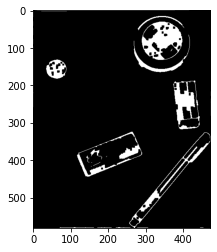

In [50]:
cntrs_median = get_contours_with_median(warped)

In [17]:
def get_contours_with_gaussian(img, thr=[50, 70]):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gau_kernel = cv2.getGaussianKernel(ksize=7, sigma=1)
    img_blur = cv2.GaussianBlur(img_gray, (7, 7), 0)
    img_canny = cv2.Canny(img_blur, thr[0], thr[1])
    kernel = np.ones((5,5))
    img_dia = cv2.dilate(img_canny, None, 1)
    img_thrld = cv2.erode(img_dia, None, 1)
    contours = cv2.findContours(img_thrld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    (final_contours, _) = imutils.contours.sort_contours(contours)
    plt.imshow(img_thrld, 'gray')
    return final_contours

6

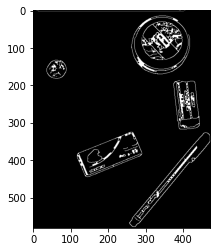

In [18]:
cntrs_gaussian = get_contours_with_gaussian(warped)
len(cntrs_gaussian)

In [20]:
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),(255, 0, 255))

In [21]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [22]:
def get_size(image, box, pixel_per_cm):
    (tl, tr, br, bl) = box
    mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
    mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
    wid = dist.euclidean(tl, tr)/pixel_per_cm
    ht = dist.euclidean(tr, br)/pixel_per_cm
    cv2.putText(image, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2.putText(image, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

In [48]:
def get_distance(resizedImg, cnts, refObj_width, tune, refObj=None):

    for c in cnts:
        
        orig = resizedImg.copy()
#         orig = resizedImg
        
        if cv2.contourArea(c) < tune:
            continue
            
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.array(box)
    
        box = order_points(box)

        cX = np.average(box[:, 0])
        cY = np.average(box[:, 1])

        if refObj is None:
            (tl, tr, br, bl) = box
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            refObj = (box, (cX, cY), D / refObj_width) 

            continue
        
        
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)

        refCoords = np.vstack([refObj[0], refObj[1]])
        objCoords = np.vstack([box, (cX, cY)])
    
        mid_pt_horizontal = (tl[0] + int(abs(tr[0] - tl[0])/2), tl[1] + int(abs(tr[1] - tl[1])/2))
        mid_pt_verticle = (tr[0] + int(abs(tr[0] - br[0])/2), tr[1] + int(abs(tr[1] - br[1])/2))
        wid = dist.euclidean(tl, tr)/refObj[2]
        ht = dist.euclidean(tr, br)/refObj[2]
        cv2.putText(orig, "{:.1f}cm".format(wid), (int(mid_pt_horizontal[0] - 15), int(mid_pt_horizontal[1] - 10)), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(orig, "{:.1f}cm".format(ht), (int(mid_pt_verticle[0] + 10), int(mid_pt_verticle[1])), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2) 
        
        get_size(orig, box, refObj[2]) 

        for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
            cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
            cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
            cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)), color, 2)
            D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
            (mX, mY) = midpoint((xA, yA), (xB, yB))
            cv2.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
        plt.figure(figsize=(12,10))
        plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))

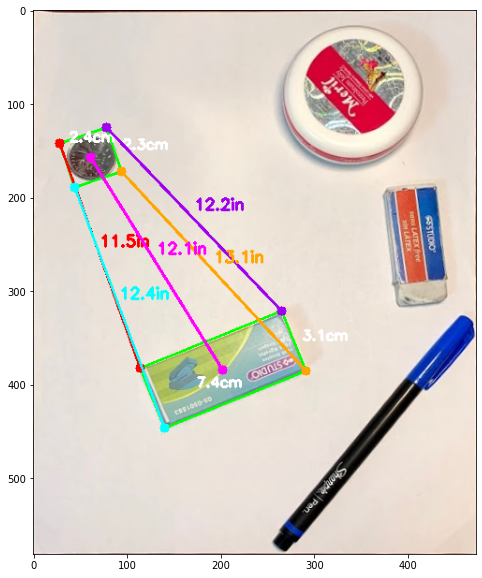

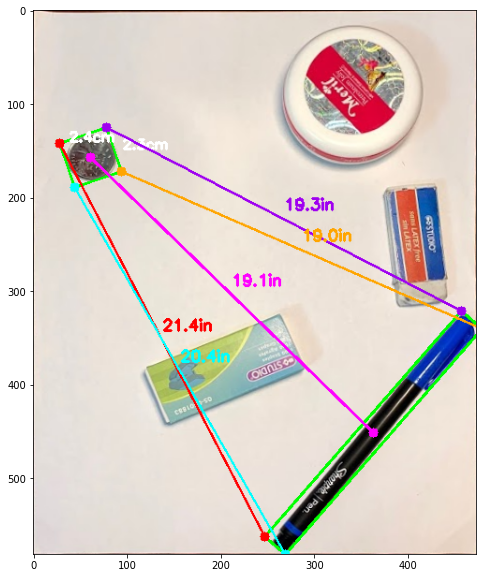

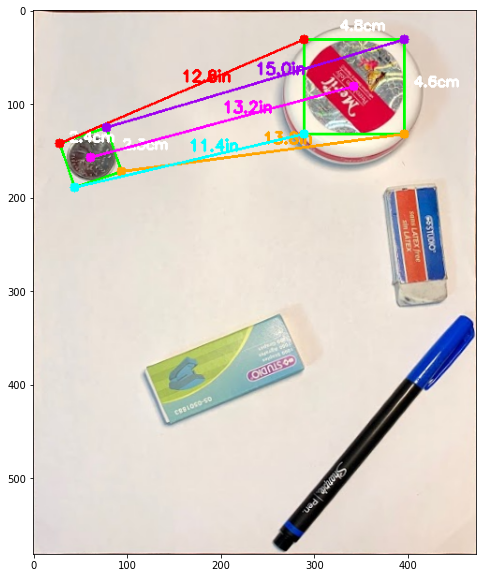

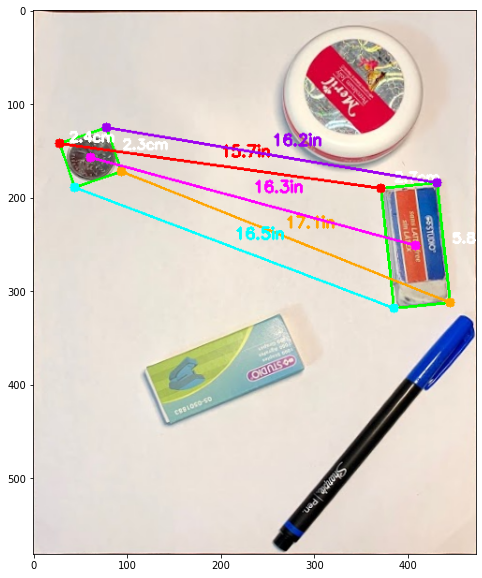

In [51]:
get_distance(warped, cntrs_median, 2.388,tune=1200)

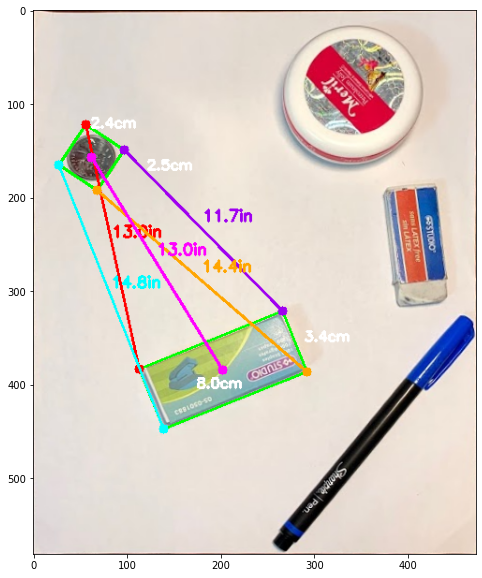

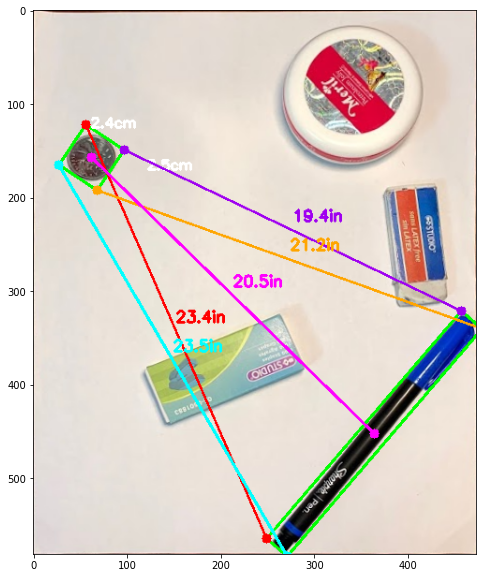

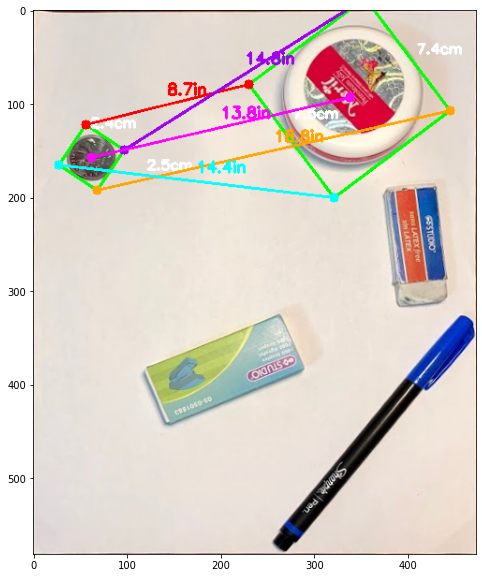

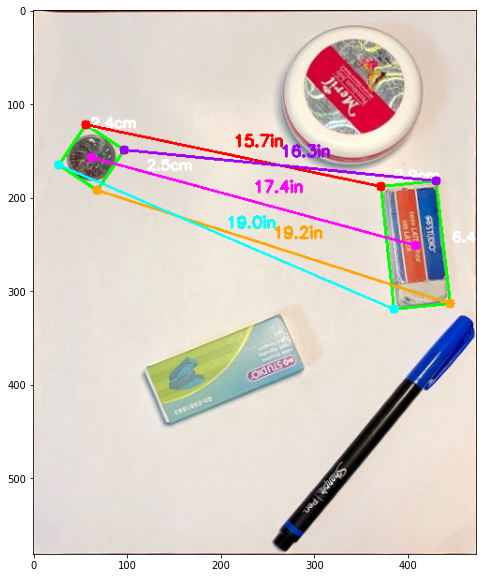

In [52]:
get_distance(warped, cntrs_gaussian, 2.388,tune=1000)